# Texas
We will be analyzing the congressional district map in Texas followwing the 2020 census. Currently Texas's congressional map is in litigation so we want to examine how that could have effected the 2024 U.S. House election. We will be looking at their 2021 plan which was used for the 2022 and 2024 election.

## Import Required Packages

In [33]:
# For working with graphs
import networkx as nx

# For making plots
import matplotlib.pyplot as plt
import numpy as np

# For getting graph
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition

# For making and working with shapefiles
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup
from maup import smart_repair, quick_repair

## Setting up our dataset
We want all the senate election results and voter demographics by precincts, so we will have to merge different datasets to do so. This section works through the code to create our desired shapefile dataset which we will save to github so we don't have to run the joins everytime we do analysis.

### Import Congressional Districting Plans

In [34]:
tx_2021_gdf = gpd.read_file("PLANC2193/PLANC2193.shp")

We need to confirm that there aren't any issues in the Districts, so we can use the "maup" package.

In [35]:
# Check geodataframe using maup's doctor function
maup.doctor(tx_2021_gdf)

True

We are good to use these shapefiles.

### Import and Tidy Election Data

In [36]:
# Import 2020 General Election voting data
tx_data_gdf = gpd.read_file('tx_2020/tx_2020.shp')

In [37]:
# List of specific columns to keep
columns_to_keep = ['CNTY', 'PREC', 'PCTKEY', 'geometry', 'G20PRERTRU', 'G20PREDBID']

# Filter the GeoDataFrame
tx_data_gdf = tx_data_gdf[columns_to_keep]

# Check that we've kept the right stuff
tx_data_gdf

,CNTY,PREC,PCTKEY,geometry,G20PRERTRU,G20PREDBID
0,113,1104,1131104,"POLYGON ((1314208.406 1178220.110, 1314211.847...",221,1173
1,201,0312,2010312,"POLYGON ((1432565.993 851290.217, 1432575.099 ...",1124,1460
2,351,0003,3510003,"POLYGON ((1602738.373 1008175.555, 1602745.401...",412,28
3,181,0304,1810304,"POLYGON ((1312523.436 1279889.507, 1312544.741...",1290,676
4,201,0877,2010877,"POLYGON ((1409146.792 864246.161, 1409155.944 ...",1352,2554
...,...,...,...,...,...,...
9009,61,0106,610106,"POLYGON ((1255418.897 426829.361, 1255403.935 ...",638,877
9010,61,0073,610073,"POLYGON ((1252204.610 425619.105, 1252185.198 ...",857,1446
9011,61,0100,610100,"POLYGON ((1252591.226 431536.955, 1252583.487 ...",804,1169
9012,61,0095,610095,"POLYGON ((1262061.387 438158.516, 1262098.888 ...",211,311


It has a geometry column so let's confirm there aren't any issues before we proceed

In [38]:
maup.doctor(tx_data_gdf)

There are 4 holes.
There are some invalid geometries.


False

We need to fix this.

In [39]:
# Find the invalid geometries
invalid_geom_indexes = ~tx_data_gdf['geometry'].is_valid
invalid_geom_indexes
# Get the rows of the data frame with invalid geometries
invalid_geom = tx_data_gdf[invalid_geom_indexes]

In [40]:
# Repair invalid geometries using buffer
tx_data_gdf.loc[~tx_data_gdf['geometry'].is_valid, 'geometry'] = tx_data_gdf.loc[~tx_data_gdf['geometry'].is_valid, 'geometry'].buffer(0)

In [41]:
# Check if there are any more invalid geometries
invalid_geom_indexes2 =  ~tx_data_gdf['geometry'].is_valid
invalid_geom2 = tx_data_gdf[invalid_geom_indexes2]
invalid_geom2
#There are no more invalid geometries!

,CNTY,PREC,PCTKEY,geometry,G20PRERTRU,G20PREDBID


In [42]:
# run maup's doctor function again to check the geodataframe again
maup.doctor(tx_data_gdf)
# No more invalid geometries!  
# Same number of holes as before, so we still need to address those

There are 4 holes.


False

Since there aren't many holes, I am going to fix them now.

In [43]:
# Do the repair
tx_data_gdf = smart_repair(tx_data_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:95: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  geometries_df["geometry"][i] = shapely.wkb.loads(
/Users/annef/anaconda3/envs/polidist/lib/python3.11/si

Snapping all geometries to a grid with precision 10^( -4 ) to avoid GEOS errors.


/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:372: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pieces_df["polygon indices"][i] = set()


Identifying overlaps...


/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:415: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pieces_df["polygon indices"][i] = pieces_df["polygon indices"][i].union({j})


Resolving overlaps...


/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:487: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  geometries_df["geometry"][this_poly_ind] = unary_union([geometries_df["geometry"][this_poly_ind], this_

Filling gaps...


Gaps to simplify:   0%|          | 0/4 [00:00<?, ?it/s]/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/smart_repair.py:1207: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  holes_df.geometry[h_ind] = orient(holes_df.geom

In [44]:
maup.doctor(tx_data_gdf)

True

### Assign Congressional Districts

Now we will assign precincts to congressional districts.

In [45]:
precincts_to_districts = maup.assign(tx_data_gdf.geometry, tx_2021_gdf.geometry)
precincts_to_districts

0       31
1        6
2       35
3        3
4        7
        ..
9009    33
9010    33
9011    33
9012    33
9013    33
Length: 9014, dtype: int64

In [46]:
# Check that the assingment went smootly: that all precints have an assigned congressional district
tx_data_gdf[precincts_to_districts.isna()]

,CNTY,PREC,PCTKEY,geometry,G20PRERTRU,G20PREDBID


Now we will add these two assignment columns to the election data geodataframe so that we know what congressional district the precinct is in for the 2021 plan.

In [47]:
tx_data_gdf["DIST2021"] = precincts_to_districts
tx_data_gdf

,CNTY,PREC,PCTKEY,geometry,G20PRERTRU,G20PREDBID,DIST2021
0,113,1104,1131104,"POLYGON ((1314208.406 1178220.110, 1314211.846...",221,1173,31
1,201,0312,2010312,"POLYGON ((1432565.993 851290.217, 1432575.099 ...",1124,1460,6
2,351,0003,3510003,"POLYGON ((1602738.373 1008175.555, 1602745.401...",412,28,35
3,181,0304,1810304,"POLYGON ((1312523.436 1279889.507, 1312544.741...",1290,676,3
4,201,0877,2010877,"POLYGON ((1409146.792 864246.161, 1409155.944 ...",1352,2554,7
...,...,...,...,...,...,...,...
9009,61,0106,610106,"POLYGON ((1253152.565 424277.522, 1253115.136 ...",638,877,33
9010,61,0073,610073,"POLYGON ((1250660.982 426477.498, 1250685.667 ...",857,1446,33
9011,61,0100,610100,"POLYGON ((1249306.311 431401.003, 1249321.330 ...",804,1169,33
9012,61,0095,610095,"POLYGON ((1260747.605 438229.231, 1261115.060 ...",211,311,33


### Join Census Demographic Data with the VTD Voting Data
The census data provides up data about voter demographics by blocks. However, we want it by precincts since our voting data is grouped by precincts.

In [49]:
# Import the Census Data, which is in a .csv format
tx_blocks = pd.read_csv('DECENNIALPL2020.P2/DECENNIALPL2020.P2-Data.csv')

# Remove first row
tx_blocks = tx_blocks.iloc[1:]

# Reset the index
tx_blocks.reset_index(drop=True, inplace=True)

# Edit the geo id column
tx_blocks['GEO_ID'] = tx_blocks['GEO_ID'].str[9:]

# Keep only the columns counting hispanic population, not hispanic white population, not hispanic black population
tx_blocks = tx_blocks[["GEO_ID", "NAME", "P2_001N", "P2_002N", "P2_003N", "P2_005N", "P2_006N"]]

/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_3651/3644538492.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  tx_blocks = pd.read_csv('DECENNIALPL2020.P2/DECENNIALPL2020.P2-Data.csv')


In [56]:
# Let's rename the population columns
tx_blocks.rename(columns={'P2_001N': 'TOTPOP', 'P2_002N': 'HISPPOP', 'P2_003N' : 'NHPOP', 
                            'P2_005N': 'NHWH', 'P2_006N': 'NHBLK'}, inplace=True)

In [57]:
tx_blocks

,GEO_ID,NAME,TOTPOP,HISPPOP,NHPOP,NHWH,NHBLK
0,480019501001000,"Block 1000, Block Group 1, Census Tract 9501, ...",39,8,31,24,7
1,480019501001001,"Block 1001, Block Group 1, Census Tract 9501, ...",89,2,87,79,5
2,480019501001002,"Block 1002, Block Group 1, Census Tract 9501, ...",14,0,14,9,2
3,480019501001003,"Block 1003, Block Group 1, Census Tract 9501, ...",0,0,0,0,0
4,480019501001004,"Block 1004, Block Group 1, Census Tract 9501, ...",7,0,7,6,0
...,...,...,...,...,...,...,...
668752,485079503025020,"Block 5020, Block Group 5, Census Tract 9503.0...",22,22,0,0,0
668753,485079503025021,"Block 5021, Block Group 5, Census Tract 9503.0...",96,96,0,0,0
668754,485079503025022,"Block 5022, Block Group 5, Census Tract 9503.0...",24,24,0,0,0
668755,485079503025023,"Block 5023, Block Group 5, Census Tract 9503.0...",20,16,4,4,0


In [58]:
# Import the shapefile block data
tx_block_gdf = gpd.read_file("tl_2022_48_tabblock20/tl_2022_48_tabblock20.shp")

In [59]:
tx_block_gdf = tx_block_gdf[['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20', 'NAME20', 'POP20', 'geometry']]
tx_block_gdf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,POP20,geometry
0,48,389,950600,1156,483899506001156,Block 1156,0,"POLYGON ((-103.65245 31.39959, -103.65243 31.3..."
1,48,389,950600,1275,483899506001275,Block 1275,0,"POLYGON ((-103.65237 31.37411, -103.65105 31.3..."
2,48,389,950200,3042,483899502003042,Block 3042,12,"POLYGON ((-103.50041 31.42155, -103.50021 31.4..."
3,48,389,950400,3012,483899504003012,Block 3012,0,"POLYGON ((-103.50150 31.41466, -103.50123 31.4..."
4,48,389,950200,1018,483899502001018,Block 1018,32,"POLYGON ((-103.50928 31.42838, -103.50924 31.4..."
...,...,...,...,...,...,...,...,...
668752,48,075,950100,2002,480759501002002,Block 2002,0,"POLYGON ((-100.27961 34.44020, -100.27955 34.4..."
668753,48,075,950100,1401,480759501001401,Block 1401,0,"POLYGON ((-100.27917 34.44133, -100.27896 34.4..."
668754,48,075,950200,4008,480759502004008,Block 4008,14,"POLYGON ((-100.21293 34.43812, -100.21285 34.4..."
668755,48,075,950200,5013,480759502005013,Block 5013,102,"POLYGON ((-100.23728 34.43410, -100.23727 34.4..."


In [60]:
# Now let's check if there are issues with the geometry
# maup.doctor(tx_block_gdf)
# There aren't but it takes a while to run so it is commented out for effiency

In [61]:
# Now we join the shapefile block data with the census data
tx_block_gdf = tx_block_gdf.merge(tx_blocks, left_on = ["GEOID20"], right_on = ["GEO_ID"], how = "left")

In [62]:
tx_block_gdf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,POP20,geometry,GEO_ID,NAME,TOTPOP,HISPPOP,NHPOP,NHWH,NHBLK
0,48,389,950600,1156,483899506001156,Block 1156,0,"POLYGON ((-103.65245 31.39959, -103.65243 31.3...",483899506001156,"Block 1156, Block Group 1, Census Tract 9506, ...",0,0,0,0,0
1,48,389,950600,1275,483899506001275,Block 1275,0,"POLYGON ((-103.65237 31.37411, -103.65105 31.3...",483899506001275,"Block 1275, Block Group 1, Census Tract 9506, ...",0,0,0,0,0
2,48,389,950200,3042,483899502003042,Block 3042,12,"POLYGON ((-103.50041 31.42155, -103.50021 31.4...",483899502003042,"Block 3042, Block Group 3, Census Tract 9502, ...",12,9,3,3,0
3,48,389,950400,3012,483899504003012,Block 3012,0,"POLYGON ((-103.50150 31.41466, -103.50123 31.4...",483899504003012,"Block 3012, Block Group 3, Census Tract 9504, ...",0,0,0,0,0
4,48,389,950200,1018,483899502001018,Block 1018,32,"POLYGON ((-103.50928 31.42838, -103.50924 31.4...",483899502001018,"Block 1018, Block Group 1, Census Tract 9502, ...",32,31,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668752,48,075,950100,2002,480759501002002,Block 2002,0,"POLYGON ((-100.27961 34.44020, -100.27955 34.4...",480759501002002,"Block 2002, Block Group 2, Census Tract 9501, ...",0,0,0,0,0
668753,48,075,950100,1401,480759501001401,Block 1401,0,"POLYGON ((-100.27917 34.44133, -100.27896 34.4...",480759501001401,"Block 1401, Block Group 1, Census Tract 9501, ...",0,0,0,0,0
668754,48,075,950200,4008,480759502004008,Block 4008,14,"POLYGON ((-100.21293 34.43812, -100.21285 34.4...",480759502004008,"Block 4008, Block Group 4, Census Tract 9502, ...",14,6,8,8,0
668755,48,075,950200,5013,480759502005013,Block 5013,102,"POLYGON ((-100.23728 34.43410, -100.23727 34.4...",480759502005013,"Block 5013, Block Group 5, Census Tract 9502, ...",102,14,88,70,10


This shapefile has all the census data by block shapefile. Now we want to aggregate up the block demographic data to be precinct data to then join to the precinct voting data.

In [63]:
# Check that we didn't loose any population
pop_cols = ['TOTPOP', 'HISPPOP', 'NHPOP', "NHWH", "NHBLK"]

# The CRS for the data file is not a EPSG so we will change it to that of the blocks
tx_data_gdf = tx_data_gdf.to_crs("EPSG:4269")

# How blocks are inputted into the precinct shapefile dataframe
blocks_to_precincts_assignment = maup.assign(tx_block_gdf.geometry, tx_data_gdf.geometry)

# We need to get all the data types of P1 to ints
for item in pop_cols:
    tx_block_gdf[item] = pd.to_numeric(tx_block_gdf[item])

tx_data_gdf[pop_cols] = tx_block_gdf[pop_cols].groupby(blocks_to_precincts_assignment).sum()

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)

In [64]:
# Check that we didn't loose any population
tx_data_gdf[pop_cols].head()

print(tx_data_gdf[pop_cols].sum())

print(tx_data_gdf[pop_cols].sum())

TOTPOP     29145505.0
HISPPOP    11441717.0
NHPOP      17703788.0
NHWH       11584597.0
NHBLK       3444712.0
dtype: float64
TOTPOP     29145505.0
HISPPOP    11441717.0
NHPOP      17703788.0
NHWH       11584597.0
NHBLK       3444712.0
dtype: float64


In [65]:
# Check to see if there are na values
tx_data_gdf[tx_data_gdf["TOTPOP"].isna()]

,CNTY,PREC,PCTKEY,geometry,G20PRERTRU,G20PREDBID,DIST2021,TOTPOP,HISPPOP,NHPOP,NHWH,NHBLK
1625,201,0922,2010922,"POLYGON ((-95.38447 29.73225, -95.38450 29.732...",0,0,6,NaN,NaN,NaN,NaN,NaN
6902,113,4650,1134650,"POLYGON ((-96.93431 32.78661, -96.93412 32.786...",0,0,5,NaN,NaN,NaN,NaN,NaN
6942,453,0127,4530127,"POLYGON ((-97.62024 30.33127, -97.62144 30.331...",0,0,34,NaN,NaN,NaN,NaN,NaN
8828,41,0104,410104,"POLYGON ((-96.32636 30.70213, -96.32646 30.702...",0,0,9,NaN,NaN,NaN,NaN,NaN
8855,113,3114,1133114,"POLYGON ((-97.01425 32.57878, -97.01343 32.577...",2,2,29,NaN,NaN,NaN,NaN,NaN


In [66]:
tx_data_gdf = tx_data_gdf.fillna(0)

In [67]:
# Double check it's all good
maup.doctor(tx_data_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


True

### Check that the joins wen smootly

In [68]:
check_gdf = tx_data_gdf.copy()

<Axes: >

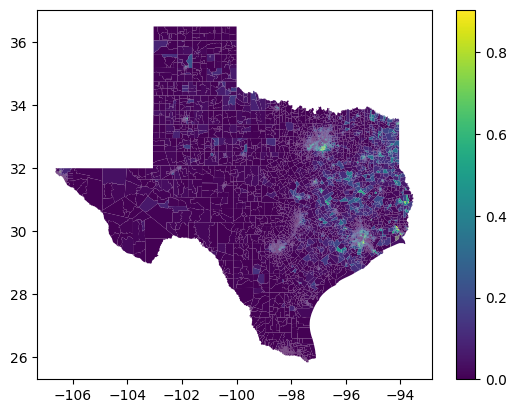

In [69]:
# Plot the black population percentage by precincts
check_gdf['b_frac'] = pd.to_numeric(check_gdf['NHBLK'])/pd.to_numeric(check_gdf['TOTPOP'])
check_gdf.plot(column = 'b_frac', missing_kwds = {"color":"grey"}, legend=True)

<Axes: >

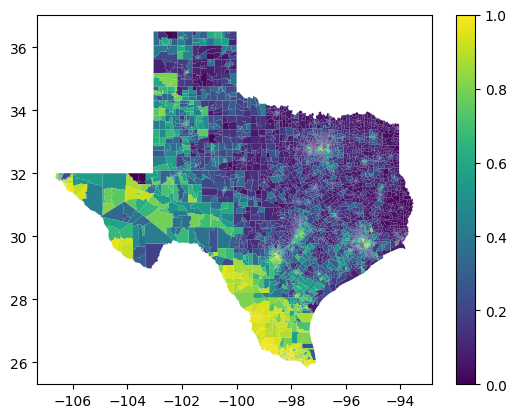

In [70]:
# Plot the hispanic population percentage by precincts
check_gdf['h_frac'] = pd.to_numeric(check_gdf['HISPPOP'])/pd.to_numeric(check_gdf['TOTPOP'])
check_gdf.plot(column = 'h_frac', missing_kwds = {"color":"grey"}, legend=True)

<Axes: >

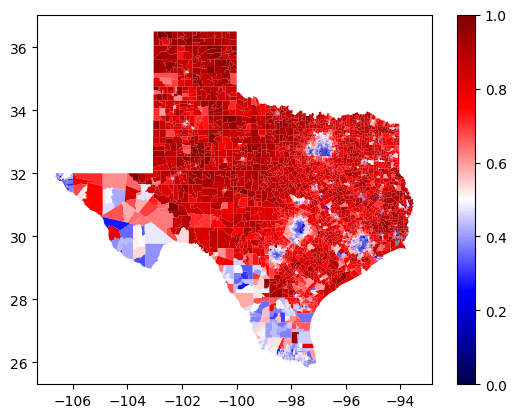

In [71]:
# Plot the senate republican votes by precincts
check_gdf['pres_r_perc'] = pd.to_numeric(check_gdf['G20PRERTRU'])/pd.to_numeric(check_gdf["G20PRERTRU"] + check_gdf["G20PREDBID"])
check_gdf.plot(column = 'pres_r_perc', cmap = "seismic", missing_kwds = {"color":"grey"}, legend=True)

Looks like it!

## Saving

In [72]:
# Save data to a shapefile so we don't have to join all the data again
tx_data_gdf.to_file("./save-new-data/tx-election-census-data-by-precincts.shp")